# Home credit default risk 

## Predicting the capabilities of repaying a loan by an applicant


In [6]:
from pyspark.sql import SparkSession

In [18]:
import initShared

In [19]:
initShared.initialize()

## 1. Importing Custom Libraries

In [7]:
import S3Serializer
import cleanlib
import EncodeLib
import Model_Fit
import Feature_Importance

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## 2. Creating spark Instance


#### Creating a session named 'HomeCredit'

In [8]:
spark = SparkSession.builder.appName('HomeCredit').getOrCreate()

## TODO: 2.5 Add a step to schedule/invoke data ingestion and showcase it here

## 3. Connecting to remote cluster using S3Bucket library

In [11]:
s3=S3Serializer.S3Bucket()
s3.connect(host = "18.212.194.194", username = "centos", key = './InternalPOC_Digital.pem')


Connecting to host  18.212.194.194
Connected


## 4. Getting data from remote cluster

In [12]:
s3.get_dir_remote('home_credit','home_credit')

Getting data...
Getting File--> part-00000-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet
Getting File--> part-00001-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet
Getting File--> part-00002-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet
Getting File--> part-00003-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet
Getting File--> _SUCCESS
['part-00000-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet', 'part-00001-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet', 'part-00002-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet', 'part-00003-ba0f831d-c1e9-4a84-aebd-6fe75d857d71-c000.snappy.parquet', '_SUCCESS']


## 5. Loading data

In [13]:
data=spark.read.parquet('./home_credit')

In [14]:
data.show(1)

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+------------------+-------------------+--------------+----------------+---------------------------+---------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+--------------------

In [15]:
len(data.columns)

122

## 6. Data Cleansing using Data_Cleaning library

##### Data_Cleaning library does:
1. Removes the highest null value column(30%)
2. Imputes the remaining null containing columns with frequent occuring value of the respective columns

In [17]:
cln = cleanlib.DataCleaningLib()

In [18]:
data=cln.cleaning(data)

1.Data Cleaning and Preprocessing
processing--> SK_ID_CURR
processing--> TARGET
processing--> NAME_CONTRACT_TYPE
processing--> CODE_GENDER
processing--> FLAG_OWN_CAR
processing--> FLAG_OWN_REALTY
processing--> CNT_CHILDREN
processing--> AMT_INCOME_TOTAL
processing--> AMT_CREDIT
processing--> AMT_ANNUITY
processing--> AMT_GOODS_PRICE
processing--> NAME_TYPE_SUITE
processing--> NAME_INCOME_TYPE
processing--> NAME_EDUCATION_TYPE
processing--> NAME_FAMILY_STATUS
processing--> NAME_HOUSING_TYPE
processing--> REGION_POPULATION_RELATIVE
processing--> DAYS_BIRTH
processing--> DAYS_EMPLOYED
processing--> DAYS_REGISTRATION
processing--> DAYS_ID_PUBLISH
processing--> OWN_CAR_AGE
processing--> FLAG_MOBIL
processing--> FLAG_EMP_PHONE
processing--> FLAG_WORK_PHONE
processing--> FLAG_CONT_MOBILE
processing--> FLAG_PHONE
processing--> FLAG_EMAIL
processing--> OCCUPATION_TYPE
processing--> CNT_FAM_MEMBERS
processing--> REGION_RATING_CLIENT
processing--> REGION_RATING_CLIENT_W_CITY
processing--> WEEKDAY

In [19]:
data_pandas=data.toPandas()
y=data_pandas['TARGET'].values
data_pandas.drop(['TARGET','SK_ID_CURR'],axis=1,inplace=True)
categorical_columns=set(data_pandas.columns)-set(data_pandas._get_numeric_data().columns)
numeric_columns=data_pandas._get_numeric_data().columns
X=data_pandas[list(numeric_columns)].values

## 7. Feature Selection Using Feature_Importance library

#### Feature_Importance library contains various feature selection algorithm(LightGBM, CatBoostClassifier, RandomForestClassifier) to select the best correlated features

In [20]:
fi = Feature_Importance.Feature_Importance_Transformer(data_pandas)

Plot Top 40 feature importancesâ€¦


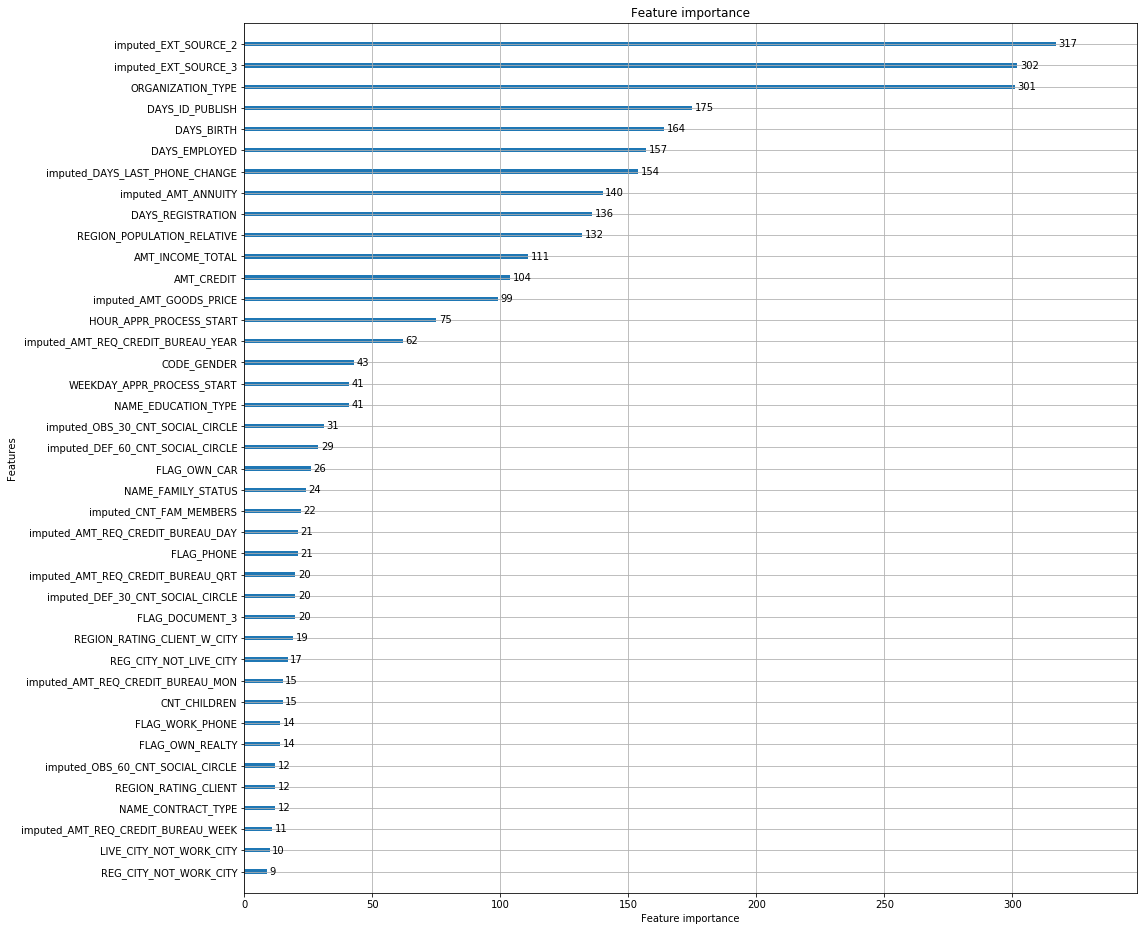

In [21]:
fi.feature_importance_lightGBM(y=y,categorical_columns=categorical_columns,n_features=40)

## 8. Label Encoding using EncodeLib library

##### EncodeLib library contains class for Label Encoding(LabelEncode) which encodes all the categorical columns in the dataframe and returns the string indexed dataframe

In [22]:
pp = EncodeLib.LabelEncode(outputCols=['TARGET'])

In [23]:
data = pp.transform(data)

NAME_INCOME_TYPE
FLAG_OWN_REALTY
CODE_GENDER
NAME_CONTRACT_TYPE
NAME_HOUSING_TYPE
ORGANIZATION_TYPE
FLAG_OWN_CAR
NAME_FAMILY_STATUS
NAME_TYPE_SUITE
NAME_EDUCATION_TYPE
WEEKDAY_APPR_PROCESS_START


## 9. One Hot Encoding using EncodeLib library

##### EncodeLib library contains class for One Hot Encoding(OHEncode) which encodes the string indexed columns in the dataframe and returns the encoded(vectors) dataframe

In [24]:
ohe = EncodeLib.OHEncode()

In [25]:
data = ohe.transform(data)

## 10. Converting independant variables to vectors using EncodeLib library

##### VectorChange class in EncodeLib library converts all the independent variables into single column named 'features'(vector) which can be used for model building

In [26]:
vec = EncodeLib.VectorChange(outputCols=['TARGET'])

In [27]:
data = vec.transform(data)

In [28]:
data.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- FLAG_MOBIL: integer (nullable = true)
 |-- FLAG_EMP_PHONE: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_CONT_MOBILE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- REGION_RATING_CLIENT: integer (nullable = true)
 |-- REGION_RATING_CLIENT_W_CITY: integer (nullable = true)
 |-- HOUR_APPR_PROCESS_START: integer (nullable = true)
 |-- REG_REGION_NOT_LIVE_REGION: integer (nullable = true)
 |-- REG_REGION_NOT_WORK_REGION: 

## 11. Model Building using Model_Fit library

##### ModelFit class in Model_Fit library applies data on classification model and returns the predcition score
-------
##### Logistic Regression

In [29]:
model1 = Model_Fit.ModelFit(inputCol='LR')

In [30]:
log_reg_pred = model1.transform(data)

In [31]:
model1._evaluate_prediction()

0.7348979169634233


##### Random Forest Classifier

In [32]:
model2 = Model_Fit.ModelFit(inputCol='RF')

In [33]:
rand_forest_pred = model2.transform(data)

In [34]:
model2._evaluate_prediction()

0.7022134904398918


## 12. Model Saving / Loading and Prediction

In [25]:
#saving Model
log_reg_pred.save('log_reg.pkl')

In [26]:
from pyspark.ml.classification import LogisticRegressionModel

In [27]:
#loading Model
mm = LogisticRegressionModel.load('log_reg.pkl')

In [28]:
#prediction
predicted=mm.transform(data)

In [29]:
predicted.select('prediction').show()

+----------+
|prediction|
+----------+
|       1.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
+----------+
only showing top 20 rows

